In [46]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta
from time import time
import numpy as np

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.utils import shuffle


Very_Start = time()

### DEFINITION DE TOUS LES PARAMETRES

In [108]:
# @param Does it save the figure ?
save_fig    = False
save_folder = 'UC2_fig'

# @param Connexion à la DB
driver   = '{ODBC Driver 17 for SQL Server}'
server   = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login    = ('DRIVER=' + driver + 
         ';SERVER='   + server + 
         ';Trusted_Connection=yes;')


# @param Definition des table et colonnes --> Dépendent de la DB
DB             = "Archive2018_2019_prod"
TABLE_CONSO    = "Consommateur"
TABLE_ENTETE   = "Recette_entete_ticket"
TEMPS_ENTETE   = TABLE_ENTETE             + ".TEMPS.KEY_Date_reel_de_la_transaction"
NUMERO_ENTETE  = TABLE_ENTETE             + ".Numero_ticket"
TABLE_DETAIL   = "Recette_detail_ticket"
TEMPS_DETAIL   = TABLE_DETAIL             + ".TEMPS.KEY_Date_reel_transaction"
NUMERO_DETAIL  = TABLE_DETAIL             + ".Numero_ticket"
TABLE_ARTICLE  = "Article_meti_HIST"
TABLE_UNIVERS  = "Univers"

Univers_Depth  = 4            # Jusqu'où on ira dans l'univers ? = [1;4]

# @param Variable influançant la sélection des données
nbr_client     = -1           # Nombre de clients à sélectionner. MAX = 148188. -1 --> ALL
client_tresh   = 15           # Nombre d'article que le client doit avoir acheter pour être mis dans un segment
univers_tresh  = 15           # Nombre d'article acheté de l'univers pour qu'il soit pris en compte

# @param Sur la normalization des données
Standard_Norm  = False        # Défini si on utilise la Normalization Standard
Standard_Tresh = 1            # Seuil d'acceptabilité des cluster en normalization standard
MinMax_Norm    = True         # Défini si on utilise la Normalization Minmax
MinMax_Tesh    = .3           # Seuil d'acceptabilité des cluster par défaut

# @param Sur le modèle KMean
K              = 14            # Nombre de segment. K = 21 -> 10% client d'exclu ; K = 15 -> 15% client exclu ; K = 9 -> 20% exclu 
n_init         = 100           # Nombre de run du KMean pour trouver le meilleur min

# @param Sur l'analyse des données
do_Analysis    = False        # Est-ce qu'on fait l'analyse des Elbow ou pas ?
Kmin           = 5            # Nombre de cluster au début de l'analyse
Kmax           = 30           # Nombre de cluster à la fin de l'analyse


# @param Hierchaical/Agglomerative Clustering
max_fitted = 10000
method     = 'ward'            # types de méthode: ward complete average single
 
# @param PCA
threeD         = False         # Afficher le graphe 3D dans les projection PCA
nbr_dim_keep   = 20            # Nombre de dimension gardée lors du KMeans effectué après un PCA    
K_PCA          = K             # K pour KMeans après le PCA

In [4]:
# TEST Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+TABLE_CONSO+".KEY] FROM ["+DB+"].[DWH].[Dim_"+TABLE_CONSO+"]", conn)
print(df)

conn.close()

   Consommateur.KEY
0                -1
1                 1
2                 2
3                 3
4                 4
5                 5
6                 6
7                 7
8                 8
9                 9


## LOAD & PREPROCESSING DATA

In [109]:
start = time()

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] AS ''' + TABLE_UNIVERS + '''
,[''' + TABLE_ENTETE + '''.KEY] AS ''' + TABLE_CONSO + '''
FROM  ['''      + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL + ''']
ON ['''    + TABLE_DETAIL  + '''.''' + TABLE_ARTICLE + '''.KEY] = [''' + TABLE_ARTICLE + '''.KEY] 
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE + '''] 
ON    [''' + TEMPS_DETAIL  +'''] = [''' + TEMPS_ENTETE  + '''] 
AND   [''' + NUMERO_DETAIL +'''] = [''' + NUMERO_ENTETE + ''']
WHERE [''' + TABLE_ARTICLE + '''.'''    + TABLE_UNIVERS  + '''.KEY] != -1 
AND ['''   + TABLE_ENTETE  + '''.Nombre_articles] > 0 
AND ['''   + TABLE_ENTETE  + '''.KEY] < ''' + str(5000000) + ''' 
AND ['''   + TABLE_ARTICLE + '''.'''    + TABLE_UNIVERS + '''.KEY] != 388'''

print(sql_command)

conn = engine.connect()
df_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 5min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_univers)
print(nbr_data)

client_tresh = 5
K = 14

SELECT [Article_meti_HIST.Univers.KEY] AS Univers
,[Recette_entete_ticket.KEY] AS Consommateur
FROM  [Archive2018_2019_prod].[DWH].[Dim_Article_meti_HIST]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_detail_ticket]
ON [Recette_detail_ticket.Article_meti_HIST.KEY] = [Article_meti_HIST.KEY] 
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket] 
ON    [Recette_detail_ticket.TEMPS.KEY_Date_reel_transaction] = [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] 
AND   [Recette_detail_ticket.Numero_ticket] = [Recette_entete_ticket.Numero_ticket]
WHERE [Article_meti_HIST.Univers.KEY] != -1 
AND [Recette_entete_ticket.Nombre_articles] > 0 
AND [Recette_entete_ticket.KEY] < 5000000 
AND [Article_meti_HIST.Univers.KEY] != 388
Time Taken to load DB: ~190secondes
14312004


In [110]:
start = time()

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] AS ''' + TABLE_UNIVERS + '''
,[''' + TABLE_ENTETE + '''.''' + TABLE_CONSO + '''.KEY] AS ''' + TABLE_CONSO + '''
FROM  ['''      + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE + '''] 
ON    [''' + TEMPS_DETAIL  +'''] = [''' + TEMPS_ENTETE  + '''] 
AND   [''' + NUMERO_DETAIL +'''] = [''' + NUMERO_ENTETE + ''']
INNER JOIN [''' + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE + ''']
ON ['''    + TABLE_DETAIL  + '''.'''    + TABLE_ARTICLE + '''.KEY] = [''' + TABLE_ARTICLE + '''.KEY] 
WHERE [''' + TABLE_ENTETE  + '''.'''    + TABLE_CONSO   + '''.KEY] > 0 
AND   [''' + TABLE_ARTICLE + '''.'''    + TABLE_UNIVERS + '''.KEY] != 388'''
if nbr_client != -1:
    sql_command +=  ''' AND [''' + TABLE_ENTETE  +'''.'''     + TABLE_CONSO   + '''.KEY] < '''  + str(nbr_client)

print(sql_command)

conn = engine.connect()
df_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 3min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_univers)
print(nbr_data)

SELECT [Article_meti_HIST.Univers.KEY] AS Univers
,[Recette_entete_ticket.Consommateur.KEY] AS Consommateur
FROM  [Archive2018_2019_prod].[DWH].[Fact_Recette_detail_ticket]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket] 
ON    [Recette_detail_ticket.TEMPS.KEY_Date_reel_transaction] = [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] 
AND   [Recette_detail_ticket.Numero_ticket] = [Recette_entete_ticket.Numero_ticket]
INNER JOIN [Archive2018_2019_prod].[DWH].[Dim_Article_meti_HIST]
ON [Recette_detail_ticket.Article_meti_HIST.KEY] = [Article_meti_HIST.KEY] 
WHERE [Recette_entete_ticket.Consommateur.KEY] > 0 
AND   [Article_meti_HIST.Univers.KEY] != 388
Time Taken to load DB: ~189secondes
10715545


In [133]:
def get_univers_correspondance(Univers_Depth):
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY],
        [''' + TABLE_UNIVERS  + '''.Libelle_univers1_FR], 
        [''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR], 
        [''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR], 
        [''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR]
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']'''

    conn = engine.connect()
    df_univers = pd.read_sql(sql_command, conn)
    conn.close()

    univers_correspondance = {}
    deleted = set()
    for item in df_univers.values:
        if item[0] in deleted:
            continue
        for cor in df_univers.values: 
            if item[0] != cor[0]:
                if (
                    item[1] == cor[1] and
                    (item[2] == cor[2] or Univers_Depth < 2) and
                    (item[3] == cor[3] or Univers_Depth < 3) and
                    (item[4] == cor[4] or Univers_Depth < 4)
                ):
                    univers_correspondance[cor[0]] = item[0]
                    deleted.add(cor[0])
    return univers_correspondance, deleted

univers_correspondance, deleted = get_univers_correspondance(Univers_Depth)

In [113]:
start = time()
dict_client_univ = {}

for i in range(nbr_data):
    univ   = df_univers[TABLE_UNIVERS][i]
    client = df_univers[TABLE_CONSO][i]
    if univ == -1:
        continue
    
    if univ in deleted:
        univ = univers_correspondance[univ]
    
    if not client in dict_client_univ:
        dict_client_univ[client] = {}
        
    if not univ in dict_client_univ[client]:
        dict_client_univ[client][univ] = 0
    dict_client_univ[client][univ] += 1

to_remove = []
for k,v in dict_client_univ.items():
    if sum(v.values()) < client_tresh:
        to_remove.append(k)
    elif not Standard_Norm:
        maxi = max(v.values())
        dict_client_univ[k] = {key:value/maxi for key,value in v.items()}

for k in to_remove:
    del dict_client_univ[k]
        
    
clients_data = pd.DataFrame(index = dict_client_univ.keys(),
                        data = dict_client_univ.values())
clients_data = clients_data.replace(float('NaN'), 0)
 
print(clients_data)

# environ 10s * nbr_client/10.000
print("Time Taken to load Dataframe: ~" + str(int(time() - start)) + "secondes")

             196       211       176       344       299       296       184  \
54086   0.043478  0.500000  0.021739  0.065217  1.000000  0.195652  0.021739   
32784   0.027027  0.027027  0.000000  0.000000  0.027027  0.000000  0.000000   
98450   0.000000  0.066667  0.000000  0.000000  0.666667  0.000000  0.000000   
84764   0.000000  0.039526  0.003953  0.000000  0.442688  0.051383  0.000000   
4565    0.000000  0.142857  0.000000  0.000000  0.031746  0.238095  0.000000   
...          ...       ...       ...       ...       ...       ...       ...   
147444  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
147509  0.000000  0.000000  0.000000  0.000000  0.500000  0.500000  0.000000   
28081   0.000000  0.500000  0.000000  0.000000  0.000000  0.000000  0.000000   
147431  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
147479  0.000000  0.000000  0.000000  0.000000  0.500000  0.000000  0.000000   

             19        335       133  .

In [114]:
# Standard Normalization
def standard_normalization(df):
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(df)
    return pd.DataFrame(index = df.index, columns = df.columns,data = scaled_values)

# Min-Max Normalization
def minmax_normalization(df):
    scaler = MinMaxScaler() 
    scaled_values = scaler.fit_transform(df) 
    return pd.DataFrame(index = df.index, columns = df.columns,data = scaled_values)

norm_clients_data = clients_data.copy()

if Standard_Norm:
    norm_clients_data = standard_normalization(norm_clients_data)
if MinMax_Norm:
    norm_clients_data = minmax_normalization(norm_clients_data)
    
if MinMax_Norm or not Standard_Norm: 
    for column in norm_clients_data:
        if sum(norm_clients_data[column]) < univers_tresh:
            norm_clients_data = norm_clients_data.drop(columns = column)

# shuffle rows        
norm_clients_data = shuffle(norm_clients_data) 
# shuffle columns
norm_clients_data = norm_clients_data[shuffle(norm_clients_data.columns)]
print(norm_clients_data)

             99        276  292  168       406  465  44   306  336  46   ...  \
57601   0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
56164   0.333333  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
77888   0.333333  0.166667  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
100252  0.000000  0.000000  0.0  0.0  0.333333  0.0  0.0  0.0  0.0  0.0  ...   
34203   0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
...          ...       ...  ...  ...       ...  ...  ...  ...  ...  ...  ...   
117800  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
126031  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
54277   0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
75051   0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
114107  0.000000  0.000000  0.0  0.0  0.031250  0.0  0.0  0.0  0.0  0.0  ...   

        238  269  255  376  10   176  1

## Analyse des données

In [115]:
def Elbow(dataframe, Kmin, Kmax):
    start = time()
    
    distorsions = []
    for k in range(Kmin, Kmax):
        print(k, end = ' ')
        model = KMeans(n_clusters=k)
        model.fit(dataframe)
        distorsions.append(model.inertia_)

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(Kmin, Kmax), distorsions)
    plt.grid(True)
    plt.title('Elbow curve')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Elbow_Curve.jpg")
    
    plt.show()
    # environ 10s*Kmax
    print("Time Taken to generate Elbow Curve : ~" + str(int(time() - start)) + "secondes")

In [116]:
def Eclude_Elbow(dataframe, Kmin, Kmax, treshold, method = 'ward', Algo= 'KMeans'):
    start = time()

    distorsions = []
    for k in range(Kmin, Kmax):
        print(k, end = ' ')
        if Algo == 'KMeans':
            model = KMeans(n_clusters=k)
        elif Algo == 'hierarchical':
            model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage=method)
        
        model.fit(dataframe)
        cluster = model.labels_
        if Algo == 'KMeans':
            cluster_centers = model.cluster_centers_
        elif Algo == 'hierarchical':
            cluster_centers = get_centroid(dataframe, cluster, k)
            cluster_centers = [cc.values() for cc in cluster_centers]
        else:
            print("Wrong Algo as input : choose beetween 'KMeans' or 'hierarchical'")
            return
        
        NACK = 0
        for i in range(len(cluster_centers)):
            if sum([(1 if c > treshold else 0) for c in cluster_centers[i]]) == 0:
                NACK += cluster.tolist().count(i)

        distorsions.append(NACK/len(cluster))

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(Kmin, Kmax), distorsions)
    plt.grid(True)
    plt.title('Exclude Elbow curve')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Exclude_Elbow_Curve.jpg")
    
    plt.show()
    

    # environ 10s*Kmax
    print("Time Taken to generate Exclude Elbow Curve : ~" + str(int(time() - start)) + "secondes")

In [117]:
def Dendogram(dataframe, mehtod = 'ward'):
    start  = time()
    method = mehtod            # types de méthode: ward complete average single
    
    plt.figure(figsize=(15, 7))  
    plt.title("Dendrograms")  
    dend = shc.dendrogram(shc.linkage(dataframe, method=method),
                          p = 50,
                          truncate_mode = 'level')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Dendogram_"+method+".jpg")
    plt.show()


    # Enivron 250s*(client/10000)²
    print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

In [118]:
def Analysis(dataframe, treshold, Kmin=5, Kmax=30, method = 'ward', Algo= 'KMeans'):
    if Algo == 'KMeans':
        Elbow(dataframe, Kmin, Kmax)   
    elif Algo == 'hierarchical':
        Dendogram(dataframe, mehtod = method)
    else:
        print("Wrong Algo as input : choose beetween 'KMeans' or 'hierarchical'")
        return
    Eclude_Elbow(dataframe, Kmin, Kmax, treshold, method, Algo)

In [119]:
def PCA_Analysis(dataframe):
    min_analyzed_dim = 0
    max_analyzed_dim = len(dataframe.columns)
    
    model_pca = PCA(n_components= max_analyzed_dim)
    predict = model_pca.fit(dataframe).transform(dataframe)
    
    total_coef = {i:1-sum(model_pca.explained_variance_ratio_[:i]) 
                  for i in range(min_analyzed_dim,max_analyzed_dim)}
    print(total_coef)
    plt.figure(figsize=(15, 7)) 
    plt.plot(total_coef.keys(), total_coef.values())
    plt.grid(True)
    plt.title('PCA Reduction : Quantitée Relative Perdue en fonction du nombre de dimension')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_PCA_Reduction_Proportion.jpg")
    
    plt.show()
if do_Analysis:
    PCA_Analysis(norm_clients_data)

## Obtention des données intéressantes

In [120]:
def get_interest(cluster_center, treshold, columns, K):
    interest = {i:[] for i in range(K)}

    for i in range(len(cluster_center)):
        for key,val in cluster_center[i].items():
            if val > tresh:
                interest[i].append(key)
                
    return interest

def print_interest(conn, interest, cluster, cluster_centers, columns):
    NACK = 0

    conn = engine.connect()
    for key,values in interest.items():
        print("\n\nCluster", key, end=': ')
        proportion = cluster.tolist().count(key)*100/len(cluster)
        print(round(proportion,2),"%",)

        if len(values) == 0:
            NACK += proportion
            continue

        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in values:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]
        #print(sql_command)

        df_libele = pd.read_sql(sql_command, conn)

        df_libele["Power"] = [round(cluster_centers[key][i],2) for i in values]

        print(df_libele.sort_values("Power", ascending=False).to_string(index=False))
    conn.close()

    print("\nNACK =", round(NACK,2),"%")
    return round(NACK,2)

In [121]:
def get_centroid(dataframe, cluster, nbr_cluster):
    cluster_center   = [{c:0 for c in norm_clients_data.columns} for _ in range(nbr_cluster)]
    proportion = [0 for _ in range(nbr_cluster)]
    for i in range(len(cluster)):
        for c in dataframe.columns:
            cluster_center[cluster[i]][c] += dataframe[c][dataframe.index[i]]
        proportion[cluster[i]]  += 1
        
    for i in range(nbr_cluster):
        for c in dataframe.columns:
            cluster_center[i][c] /= proportion[i]
            
    return cluster_center

# KMEANS

In [122]:
if do_Analysis:
    Analysis(norm_clients_data, treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh, Kmin = Kmin, Kmax = Kmax)

In [123]:
start = time()
model = KMeans(K, n_init = n_init)
model.fit(norm_clients_data)
kmeans_cluster = model.labels_
# environ 1s * n_init * K/10
print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

Time Taken to fit model : ~225secondes


In [124]:
kmeans_centers  = model.cluster_centers_
kmeans_centers  = [{norm_clients_data.columns[j]:kmeans_centers[i][j] 
                    for j in range(len(kmeans_centers[i]))} 
                   for i in range(len(kmeans_centers))]
kmeans_interest = get_interest(kmeans_centers, 
                       0.2,
                       norm_clients_data.columns, K)

print_interest(conn, kmeans_interest, kmeans_cluster, kmeans_centers, norm_clients_data.columns)



Cluster 0: 3.72 %
 Univ_KEY           Univ_1                       Univ_2         Univ_3   Univ_4  Power
      297   PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS          PAINS    PAINS   0.60
      171 FRUITS   LEGUMES                       FRUITS       EXOTIQUE EXOTIQUE   0.34
      183 FRUITS   LEGUMES                      LEGUMES AUTRES LEGUMES   FRUITS   0.24
       13  PRET A CUISINER                4 ET 5  GAMME        SALADES  SALADES   0.23


Cluster 1: 4.96 %
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4  Power
      457       BOISSONS  SOFT DRINKS          SODA         COLAS   0.92
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES   0.24


Cluster 2: 4.36 %
 Univ_KEY                     Univ_1                       Univ_2                       Univ_3                       Univ_4  Power
      296             PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS                   MINI PAINS                   MINI PAINS   0.80
      294             PE

17.71

In [125]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~4623secondes


# VISUALISATION PCA

In [22]:
def PCA_Visualisation(data, target=[], centroid=[], method = "", threeD = False):
    start = time()

    model_pca = PCA(n_components= 2)
    predict = model_pca.fit(data).transform(data)
    
    
    print('Explained variance ratio from PCA: {}'.format(model_pca.explained_variance_ratio_))
    
    plt.figure(figsize=(15, 7))  
    if list(target):
        plt.scatter(predict[:,0],predict[:,1], c=target, alpha=.8)
    else: 
        plt.scatter(predict[:,0],predict[:,1])
    if list(centroid):
        clust_predict = model_pca.transform(centroid)
        plt.scatter(clust_predict[:,0],clust_predict[:,1], color='r')
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA of dataset - ' + method + ' - Cluster = ' + str(K))

    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_PCA_Cluster-"+str(K)+"-"+method+".jpg")
    
    if threeD:
        model_pca = PCA(n_components= 3)
        predict = model_pca.fit(data).transform(data)
        print('Explained variance ratio from PCA: {}'.format(model_pca.explained_variance_ratio_))


        plt.figure(figsize=(30, 30)) 
        ax = plt.axes(projection='3d')

        ax.scatter3D(predict[:,0], predict[:,1], predict[:,2], c=target);

        plt.title('PCA of dataset in 3D - ' + method)

        if save_fig:
            plt.savefig(save_folder+"/"+str(Univers_Depth)+"_PCA_Cluster_3D-"+str(K)+"-"+method+".jpg")
    
    # environ 1.5s
    print("Time Taken to show PCA : ~" + str(int(time() - start)) + "secondes")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.0694071  0.05792984]
Time Taken to show PCA : ~1secondes


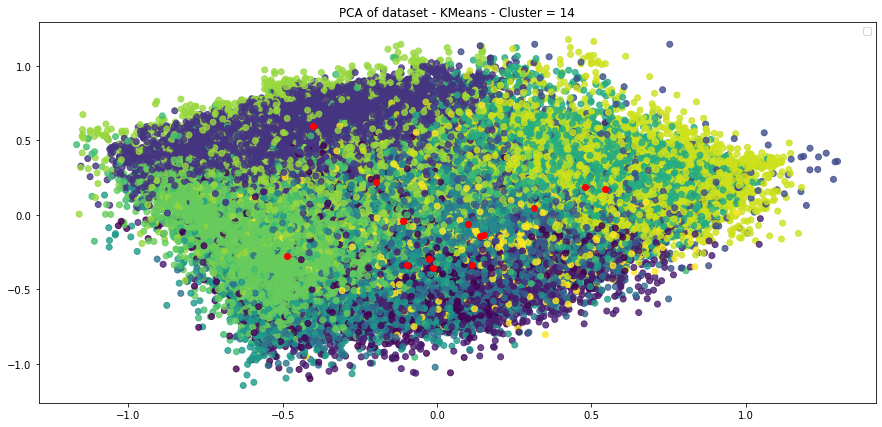

In [25]:
PCA_Visualisation(norm_clients_data,
                  kmeans_cluster, 
                  [list(dic.values()) for dic in kmeans_centers],
                  method = 'KMeans',
                  threeD = threeD)

# HIERARCHICAL CLUSTERING

In [26]:
if do_Analysis:
    Analysis(norm_clients_data.head(max_fitted),
             treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh, Kmin = Kmin, Kmax = Kmax, 
             method = 'ward', Algo= 'hierarchical')

In [27]:
start  = time()

method = method            # types de méthode: ward complete average single

hierarchical_model = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage=method)  
hierarchical_model.fit(norm_clients_data.head(max_fitted))
print(hierarchical_model)
# 15s * (N/10k)²
print("Time Taken to fit/predict model : ~" + str(int(time() - start)) + "secondes")

AgglomerativeClustering(n_clusters=14)
Time Taken to fit/predict model : ~17secondes


In [29]:
start = time()

hierarchical_cluster  = hierarchical_model.labels_
hierarchical_centroid = get_centroid(norm_clients_data, hierarchical_cluster, K)

hierarchical_interest = get_interest(hierarchical_centroid, 
                       Standard_Tresh if Standard_Norm else MinMax_Tesh,
                       norm_clients_data.columns, K)

print_interest(conn, hierarchical_interest, hierarchical_cluster, list(hierarchical_centroid), norm_clients_data.columns)

# environ 30s
print("Time Taken to get interests : ~" + str(int(time() - start)) + "secondes")



Cluster 0: 5.32 %
 Univ_KEY         Univ_1                       Univ_2    Univ_3  Power
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES   0.59
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS     PAINS   0.55


Cluster 1: 26.28 %


Cluster 2: 10.14 %
 Univ_KEY         Univ_1       Univ_2        Univ_3  Power
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES   0.89


Cluster 3: 5.09 %
 Univ_KEY        Univ_1         Univ_2        Univ_3  Power
      412 PRET A MANGER PLATS PREPARES     THAI FOOD   0.58
      402 PRET A MANGER PLATS PREPARES  CHINESE FOOD   0.40
      408 PRET A MANGER PLATS PREPARES JAPANESE FOOD   0.39


Cluster 4: 5.17 %
 Univ_KEY         Univ_1                       Univ_2        Univ_3  Power
      299 PETIT DEJEUNER                 VIENNOISERIE VIENNOISERIES   0.89
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS    MINI PAINS   0.31


Cluster 5: 7.93 %
 Univ_KEY        Univ_1         Univ_2         Univ_3  Power
      403 PRET A MANG

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.06854808 0.05771348]
Time Taken to show PCA : ~0secondes


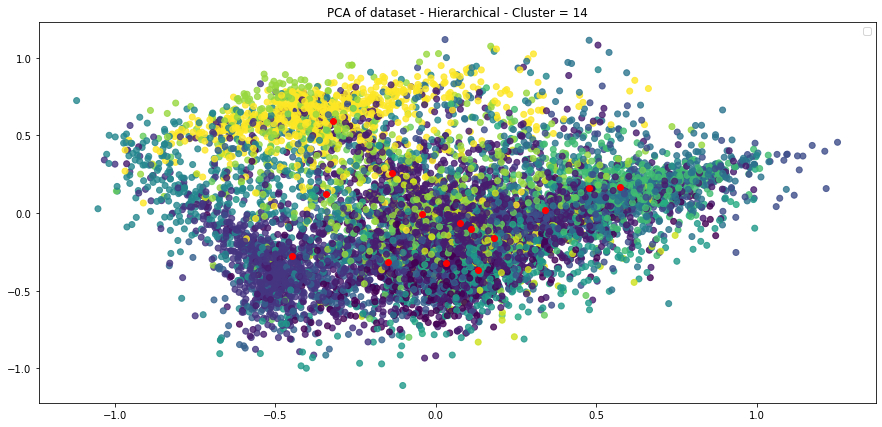

In [30]:
PCA_Visualisation(norm_clients_data.head(max_fitted), 
                  hierarchical_cluster,
                  [list(dic.values()) for dic in hierarchical_centroid],
                  method = 'Hierarchical',
                  threeD = threeD)

In [31]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~4708secondes


## PCA Dimension reductor + KMeans

In [32]:
model_pca = PCA(n_components= nbr_dim_keep)
predict = model_pca.fit(norm_clients_data).transform(norm_clients_data)

In [33]:
new_datas = pd.DataFrame(index=norm_clients_data.index, data = predict)
print(new_datas)

              0         1         2         3         4         5         6   \
68909  -0.292387  0.312130  0.181989  0.445337 -0.600451  0.530012  0.035482   
121617  0.249664  0.232644 -0.111488 -0.247418  0.275750  0.411572 -0.071175   
15019   0.084397 -0.402839 -0.349635 -0.023025  0.359399 -0.065926 -0.408755   
106979 -0.344611  0.685505 -0.451343 -0.219459  0.260906 -0.067047  0.105455   
18396   0.312034 -0.026947 -0.042774 -0.062549 -0.218764 -0.118083 -0.089665   
...          ...       ...       ...       ...       ...       ...       ...   
36497   0.128884 -0.190261 -0.485015 -0.163772 -0.069821  0.013414  0.040157   
47100  -0.152859  0.282099 -0.190522  0.550563  0.711933 -0.327611  0.493716   
43043  -0.463672 -0.488350  0.167394 -0.461901 -0.177099  0.057850  0.246883   
135256  0.126969 -0.064936 -0.474198 -0.386031 -0.125627 -0.031985 -0.052964   
82253   0.147292 -0.143753 -0.500347 -0.244458 -0.117263 -0.002280  0.036715   

              7         8         9    

In [34]:
if do_Analysis:
    Analysis(new_datas, treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh, Kmin = Kmin, Kmax = Kmax)

In [35]:
start = time()

model = KMeans(K_PCA, n_init = n_init)
model.fit(new_datas)

# environ 10s
print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

Time Taken to fit model : ~63secondes


In [37]:
start = time()

PCA_cluster  = model.labels_
PCA_centroid = get_centroid(norm_clients_data, PCA_cluster, K_PCA)        
        
PCA_interest = get_interest(PCA_centroid, 
                       Standard_Tresh if Standard_Norm else MinMax_Tesh,
                       norm_clients_data.columns, K)

print_interest(conn, PCA_interest, PCA_cluster, PCA_centroid, norm_clients_data.columns)

#environ 2min
print("Time Taken to get interests : ~" + str(int(time() - start)) + "secondes")



Cluster 0: 4.48 %
 Univ_KEY         Univ_1                       Univ_2    Univ_3  Power
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES   0.94


Cluster 1: 8.63 %
 Univ_KEY        Univ_1         Univ_2       Univ_3  Power
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD   0.97


Cluster 2: 4.18 %
 Univ_KEY        Univ_1         Univ_2        Univ_3  Power
      412 PRET A MANGER PLATS PREPARES     THAI FOOD   0.83
      408 PRET A MANGER PLATS PREPARES JAPANESE FOOD   0.38
      402 PRET A MANGER PLATS PREPARES  CHINESE FOOD   0.32


Cluster 3: 9.4 %
 Univ_KEY        Univ_1         Univ_2         Univ_3  Power
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD   0.96
      405 PRET A MANGER PLATS PREPARES   ITALIAN FOOD   0.35


Cluster 4: 5.05 %
 Univ_KEY         Univ_1                       Univ_2 Univ_3  Power
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS   0.95


Cluster 5: 12.84 %


Cluster 6: 4.35 %
 Univ_KEY          Univ_1             Uni

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.0694071  0.05792983]
Time Taken to show PCA : ~0secondes


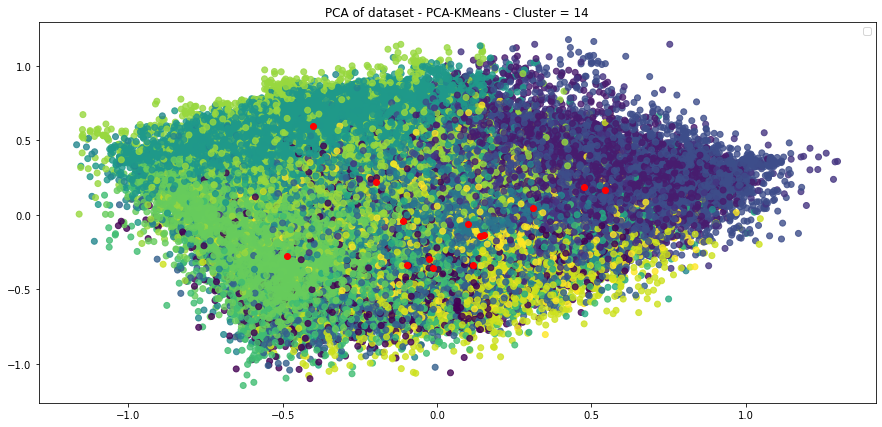

In [38]:
PCA_Visualisation(norm_clients_data, 
                  PCA_cluster, 
                  [list(dic.values()) for dic in PCA_centroid],
                  method = 'PCA-KMeans',
                  threeD = threeD)

In [39]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~5212secondes


In [44]:
print(type(model.labels_))

<class 'numpy.ndarray'>


## Reconstruction des résultats du KMeans A LA MAIN

In [126]:
algo = "KMeans"
cluster         = kmeans_cluster
cluster_centers = kmeans_centers

start = time()

cluster_correspondance = {0:0, 1:1, 2:2, 3:2, 4:3, 5:1, 6:4,7:6, 8:5, 9:2, 10:5, 11:2, 12:3, 13:3}
new_K = len(set(cluster_correspondance.values()))

new_cluster = []
for c in cluster:
    new_cluster.append(cluster_correspondance[c])
new_cluster =  np.array(new_cluster)
    
new_cluster_center = get_centroid(norm_clients_data, new_cluster, new_K)   

#environ 2min
print("Time Taken to change clusters: ~" + str(int(time() - start)) + "secondes")

In [127]:
tresh =  .3
new_interest = get_interest(new_cluster_center, 
                       tresh,
                       norm_clients_data.columns, new_K)

NACK = print_interest(conn, new_interest, new_cluster, new_cluster_center,
                      norm_clients_data.columns)   




Cluster 0: 3.72 %
 Univ_KEY           Univ_1                       Univ_2         Univ_3   Univ_4  Power
      297   PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS          PAINS    PAINS   0.60
      171 FRUITS   LEGUMES                       FRUITS       EXOTIQUE EXOTIQUE   0.34
      183 FRUITS   LEGUMES                      LEGUMES AUTRES LEGUMES   FRUITS   0.24
       13  PRET A CUISINER                4 ET 5  GAMME        SALADES  SALADES   0.23


Cluster 1: 11.24 %
 Univ_KEY         Univ_1       Univ_2            Univ_3               Univ_4  Power
      457       BOISSONS  SOFT DRINKS              SODA                COLAS   0.57
      392  PRET A MANGER   SANDWICHES SANDWICHES FROIDS SANDWICHES CLASSIQUE   0.48
      299 PETIT DEJEUNER VIENNOISERIE     VIENNOISERIES        VIENNOISERIES   0.25
      393  PRET A MANGER   SANDWICHES SANDWICHES FROIDS  SANDWICHES SPECIAUX   0.22


Cluster 2: 20.65 %
 Univ_KEY         Univ_1                       Univ_2        Univ_3        Univ_4  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.06296929 0.04933729]
Time Taken to show PCA : ~1secondes


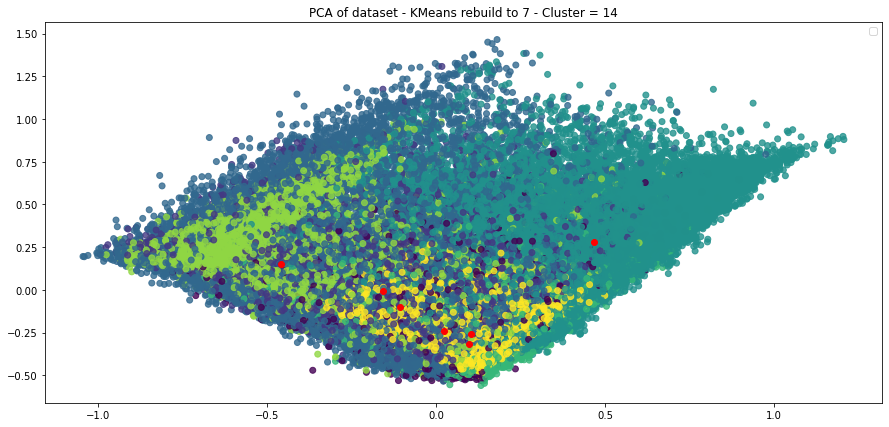

In [128]:
PCA_Visualisation(norm_clients_data, 
                  new_cluster, 
                  [list(dic.values()) for dic in new_cluster_center], 
                  method = 'KMeans rebuild to 7', 
                  threeD = threeD)

In [129]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~9271secondes


## INSERT INTO TABLE

In [130]:
sql_cmd = '''
INSERT INTO ['''+DB+'''].[PML].[Segmentation]
           ([Segmentation.K_init]
           ,[Segmentation.K]
           ,[Segmentation.NACK]
           ,[Segmentation.Algorithme]
           ,[Segmentation.Univers_Depth]
           ,[Segmentation.Client_Treshold]
           ,[Segmentation.Univers_Treshold]
           ,[Segmentation.Normalisation]
           ,[Segmentation.Treshold]
           ,[Segmentation.PCA_Nombre_Dimension_garder]
           ,[Segmentation.Hierarchical_Method])
     VALUES
           ('''+str(K if algo != "PCA" else K_PCA)+'''
           ,'''+str(new_K)+'''
           ,'''+str(NACK)+'''
           ,'''+"'"+algo+"'"+'''
           ,'''+str(Univers_Depth)+'''
           ,'''+str(client_tresh)+'''
           ,'''+str(univers_tresh)+'''
           ,'''+"'"+("Standard" if Standard_Norm else "MinMax")+"'"+'''
           ,'''+str(tresh)+'''
           ,'''+ ("Null" if algo != "PCA" else nbr_dim_keep)+'''
           ,'''+("Null" if algo != "hierarchical" else method)+''')

'''

print(sql_cmd)

conn = engine.connect()
conn.execute(sql_cmd)
conn.close()


INSERT INTO [Archive2018_2019_prod].[PML].[Segmentation]
           ([Segmentation.K_init]
           ,[Segmentation.K]
           ,[Segmentation.NACK]
           ,[Segmentation.Algorithme]
           ,[Segmentation.Univers_Depth]
           ,[Segmentation.Client_Treshold]
           ,[Segmentation.Univers_Treshold]
           ,[Segmentation.Normalisation]
           ,[Segmentation.Treshold]
           ,[Segmentation.PCA_Nombre_Dimension_garder]
           ,[Segmentation.Hierarchical_Method])
     VALUES
           (14
           ,7
           ,17.71
           ,'KMeans'
           ,4
           ,5
           ,15
           ,'MinMax'
           ,0.2
           ,Null
           ,Null)




In [131]:
sql_cmd = '''SELECT [Segmentation.KEY] FROM ['''+DB+'''].[PML].[Segmentation] ORDER BY [Segmentation.KEY] DESC'''
conn = engine.connect()
segmentation_df  = pd.read_sql(sql_cmd, conn)
segmentation_key = segmentation_df.values[0][0]
conn.close()

print(segmentation_key)

2


In [132]:
for key in range(new_K):
    proportion = round(new_cluster.tolist().count(key)*100/len(new_cluster),2)
    is_NACK    = not bool(len(new_interest[key]))
    sql_cmd = '''
    INSERT INTO ['''+DB+'''].[PML].[Segment]
               ([Segment.SEGMENTATION.KEY]
               ,[Segment.flags_NACK]
               ,[Segment.Numero_Cluster]
               ,[Segment.Proportion_Client])
         VALUES
               ('''+str(segmentation_key)+'''
               ,'''+str(int(is_NACK))+'''
               ,'''+str(key)+'''
               ,'''+str(proportion)+''')
    '''
    print(sql_cmd)
    conn = engine.connect()
    conn.execute(sql_cmd)
    conn.close()
    
    
    sql_cmd = '''SELECT [Segment.KEY] FROM ['''+DB+'''].[PML].[Segment] ORDER BY [Segment.KEY] DESC'''
    conn = engine.connect()
    segment_df  = pd.read_sql(sql_cmd, conn)
    segment_key = segment_df.values[0][0]
    conn.close()
    
    
    for univ in new_interest[key]:
        sql_cmd = '''
        INSERT INTO ['''+DB+'''].[PML].[Segment_Content]
                   ([Segment_Content.SEGMENT.KEY]
                   ,[Segment_Content.UNIVERS.KEY]
                   ,[Segment_Content.Power])
             VALUES
                   ('''+str(segment_key)+'''
                   ,'''+str(univ)+'''
                   ,'''+str(round(new_cluster_center[key][univ],2))+''')
        '''
        print(sql_cmd)
        conn = engine.connect()
        conn.execute(sql_cmd)
        conn.close()


    INSERT INTO [Archive2018_2019_prod].[PML].[Segment]
               ([Segment.SEGMENTATION.KEY]
               ,[Segment.flags_NACK]
               ,[Segment.Numero_Cluster]
               ,[Segment.Proportion_Client])
         VALUES
               (2
               ,0
               ,0
               ,3.72)
    

        INSERT INTO [Archive2018_2019_prod].[PML].[Segment_Content]
                   ([Segment_Content.SEGMENT.KEY]
                   ,[Segment_Content.UNIVERS.KEY]
                   ,[Segment_Content.Power])
             VALUES
                   (8
                   ,297
                   ,0.23)
        

        INSERT INTO [Archive2018_2019_prod].[PML].[Segment_Content]
                   ([Segment_Content.SEGMENT.KEY]
                   ,[Segment_Content.UNIVERS.KEY]
                   ,[Segment_Content.Power])
             VALUES
                   (8
                   ,171
                   ,0.34)
        

        INSERT INTO [Archive2018_2019_prod].[PML]

In [ ]:
print(norm_clients_data)
PCA_Visualisation(norm_clients_data, method = 'Standard Normalization')